<a href="https://colab.research.google.com/github/yuji-sgs/m1-reserch/blob/main/MOPSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

## 本ノートブックの目的
[前回作成したノートブック](https://github.com/yuji-sgs/m1-reserch/blob/main/Inverse_Analysis.ipynb)では深層学習モデルの1出力に対する逆解析にしか適応できなかったが、複数出力に対する逆解析を実現するために、KerasのFunctional APIを用いて複数出力の深層学習モデルを作成し、その学習済みモデルを適用して多目的粒子群最適化（MOPSO）アルゴリズムを構築していく。

## 処理フロー
1. 使用するライブラリをインポート
2. データの読み込み・確認
3. データ分割
4. KerasのFunctional APIで学習
5. 学習後の精度評価
6. MOPSO実装

## 1. 使用するライブラリをインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

import io
from google.colab import files

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.models import Model
from keras.layers import Input, Dense

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

## 2. データの読み込み・確認
ローカルにあるファイルからGoogle Colaboratoryにアップロード

In [2]:
# Google Colaboratoryでファイルをアップロード
uploaded = files.upload()

Saving data_Multiple.csv to data_Multiple.csv


In [3]:
# データフレームとして、変数dfに4列×10000行のデータを格納（C2：材料パラメータ, s：構造パラメータ, w11_max：遮音パラメータ1,　BandGap1：遮音パラメータ2）
df = pd.read_csv(io.BytesIO(uploaded['data_Multiple.csv']))
df

,C2,s,w11_max,BandGap1
0,0.15,0.01,250.00,6.689500e+00
1,0.30,0.01,353.55,5.649800e+00
2,0.45,0.01,433.01,4.264400e+00
3,0.60,0.01,500.00,2.945800e+00
4,0.75,0.01,559.02,1.748300e+00
...,...,...,...,...
9995,14.40,1.00,645.50,4.090000e-12
9996,14.55,1.00,645.50,7.840000e-12
9997,14.70,1.00,645.50,2.270000e-13
9998,14.85,1.00,645.50,4.550000e-12


## 3. データ分割
学習用データとテスト用データに分割

In [4]:
# データの分割
(train, test) = train_test_split(df, test_size=0.2, shuffle=True)

In [5]:
# x_train, x_testではcsvファイルの1, 2列目を， y_train, y_testでは3, 4列目のデータを活用
x_train = train.iloc[:, [0, 1]]
y_train = train.iloc[:, [2, 3]]

x_test = test.iloc[:, [0, 1]]
y_test = test.iloc[:, [2, 3]]

## 4. KerasのFunctional APIで学習
### モデルの概要
- 入力層：2ノード(C2, s)
- 中間層：3層, 各層64ノード
    - アウトプット直前の層にプラスで1層
- 出力層：2ノード（w11_max, BandGap1）

### 活性化関数
- ReLUを採用（勾配消失問題の解消, 処理速度が速い, 多くの場合高い性能を示す）

### 損失関数
- 回帰問題に適したMSE（平均二乗誤差）を採用

### 最適化アルゴリズム
- Adamを採用（Kingma氏らが2014年に提案した高い性能を示すことで知られている | 参考：[Adam: A Method for Stochastic Optimization](https://www.semanticscholar.org/paper/Adam%3A-A-Method-for-Stochastic-Optimization-Kingma-Ba/a6cb366736791bcccc5c8639de5a8f9636bf87e8)）
  - ハイパーパラメータは提案論文の推奨値で決定
    - lr：学習率
    - beta_1：過去の勾配の指数移動平均を計算する際の減衰係数
    - beta_2：過去の勾配の二乗の指数移動平均を計算する際の減衰係数

### その他ハイパーパラメータ
- 学習回数：300回
- バッチサイズ：64

In [6]:
# モデルの構築
# inputの数:C2, s
inputs = Input(shape=(2,))

# 学習回数
epochs = 300
batch_size = 64

# ノード数
node = 64

x1 = Dense(node, activation='relu')(inputs)
x2 = Dense(node, activation='relu')(x1)
x3 = Dense(node, activation='relu')(x2)


x4 = Dense(node, activation='relu')(x3) # アウトプット直前の層
output1 = Dense(1, name='output1')(x4)

x5 = Dense(node, activation='relu')(x3) # アウトプット直前の層
output2 = Dense(1, name='output2')(x5)

model = Model(inputs=inputs, outputs=[output1, output2])

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss=['mse', 'mse']
)

In [7]:
# 学習オプション
history = model.fit(x_train,
                    {"output1":y_train.iloc[:, [0]], "output2":y_train.iloc[:, [1]]},
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_test, {"output1":y_test.iloc[:, [0]], "output2":y_test.iloc[:, [1]]})
)

Epoch 1/300
125/125 [==============================] - 3s 8ms/step - loss: 576034.0625 - output1_loss: 432284.7500 - output2_loss: 143749.2188 - val_loss: 223910.2344 - val_output1_loss: 147560.3438 - val_output2_loss: 76349.9609
Epoch 2/300
125/125 [==============================] - 1s 5ms/step - loss: 208299.5625 - output1_loss: 127994.9609 - output2_loss: 80304.6328 - val_loss: 183188.8125 - val_output1_loss: 103770.1875 - val_output2_loss: 79418.6562
Epoch 3/300
125/125 [==============================] - 0s 3ms/step - loss: 171826.7031 - output1_loss: 91252.0156 - output2_loss: 80574.6328 - val_loss: 145804.9219 - val_output1_loss: 70467.2812 - val_output2_loss: 75337.6328
Epoch 4/300
125/125 [==============================] - 0s 3ms/step - loss: 131355.3906 - output1_loss: 58854.1914 - output2_loss: 72501.2500 - val_loss: 105084.5234 - val_output1_loss: 41464.0664 - val_output2_loss: 63620.4297
Epoch 5/300
125/125 [==============================] - 0s 3ms/step - loss: 99798.5156 -

In [8]:
# 構築したモデルで予測
pred1, pred2 = model.predict(x_test)

63/63 [==============================] - 1s 5ms/step


## 5. 学習後の精度評価

## 精度評価指標
### MAE（Mean Absolute Error | 平均絶対誤差）
- 各データに対して「予測値と正解値の差(=誤差)」の絶対値を計算し、その総和をデータ数で割った値(=平均値)を出力する関数。0に近いほど良い。

### RMSE（Root Mean Squared Error | 二乗平均平方根誤差）
- 各データに対して「予測値と正解値の差(=誤差)」の二乗値を計算し, その総和をデータ数で割った値(=平均値)の平方根をとって出力する関数。0に近いほど良い。

### 決定係数（Coefficient of Determination | R^2）
- 出力の実測値と出力の予測値の間の相関係数を表す。1に近づくをほど良い。

参考：https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/

In [10]:
#精度評価指標
# Output1 ====================================================================
print("=======  Output1  =======")
# MAE
test_MAE = mean_absolute_error(y_test.iloc[:, 0], pred1)
print('MAE：', test_MAE)

# RMSE
test_RMSE = sqrt(mean_squared_error(y_test.iloc[:, 0], pred1))
print('RMSE：', test_RMSE)

# 決定係数
R2 = r2_score(y_test.iloc[:, 0], pred1)
print('R2：', R2)

print("")

# Output2 ====================================================================
print("=======  Output2  =======")
# MAE
test_MAE = mean_absolute_error(y_test.iloc[:, 1], pred2)
print('MAE：', test_MAE)

# RMSE
test_RMSE = sqrt(mean_squared_error(y_test.iloc[:, 1], pred2))
print('RMSE：', test_RMSE)

# 決定係数
R2 = r2_score(y_test.iloc[:, 1], pred2)
print('R2：', R2)

=======  Output1  =======
MAE： 3.079655527954102
RMSE： 5.126881964817122
R2： 0.9996647932179069

=======  Output2  =======
MAE： 3.883299006085918
RMSE： 5.8796907821871205
R2： 0.9996431635216084


Text(0, 0.5, 'loss')

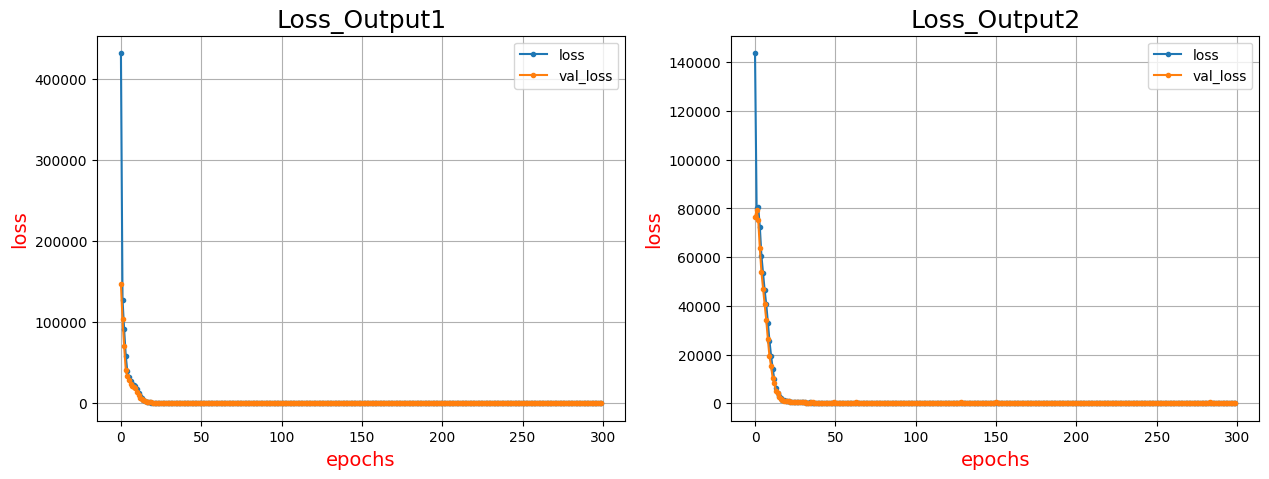

In [11]:
# Figureを追加
fig = plt.figure(figsize = (15, 5))

# Output1 ====================================================================
# 1×2 の1枚目に描画する
loss_graph1 = fig.add_subplot(1, 2, 1)

# x,yに要素追加
loss1 = history.history['output1_loss']
val_loss1 = history.history['val_output1_loss']
epochs1 = len(loss1)

# グラフ設定
loss_graph1.plot(range(epochs), loss1, marker='.', label='loss')
loss_graph1.plot(range(epochs), val_loss1, marker='.', label='val_loss')
loss_graph1.set_title("Loss_Output1", size = 18)
loss_graph1.legend(loc='best')
loss_graph1.grid()
loss_graph1.set_xlabel("epochs", size = 14, color = "r")
loss_graph1.set_ylabel("loss", size = 14, color = "r")

#==============================================================================
# Output2 ====================================================================
# 1×2 の2枚目に描画する
loss_graph2 = fig.add_subplot(1, 2, 2)

# x,yに要素追加
loss2 = history.history['output2_loss']
val_loss2 = history.history['val_output2_loss']
epochs2 = len(loss2)

# グラフ設定
loss_graph2.plot(range(epochs), loss2, marker='.', label='loss')
loss_graph2.plot(range(epochs), val_loss2, marker='.', label='val_loss')
loss_graph2.set_title("Loss_Output2", size = 18)
loss_graph2.legend(loc='best')
loss_graph2.grid()
loss_graph2.set_xlabel("epochs", size = 14, color = "r")
loss_graph2.set_ylabel("loss", size = 14, color = "r")
#==============================================================

Text(0, 0.5, 'predicted_data')

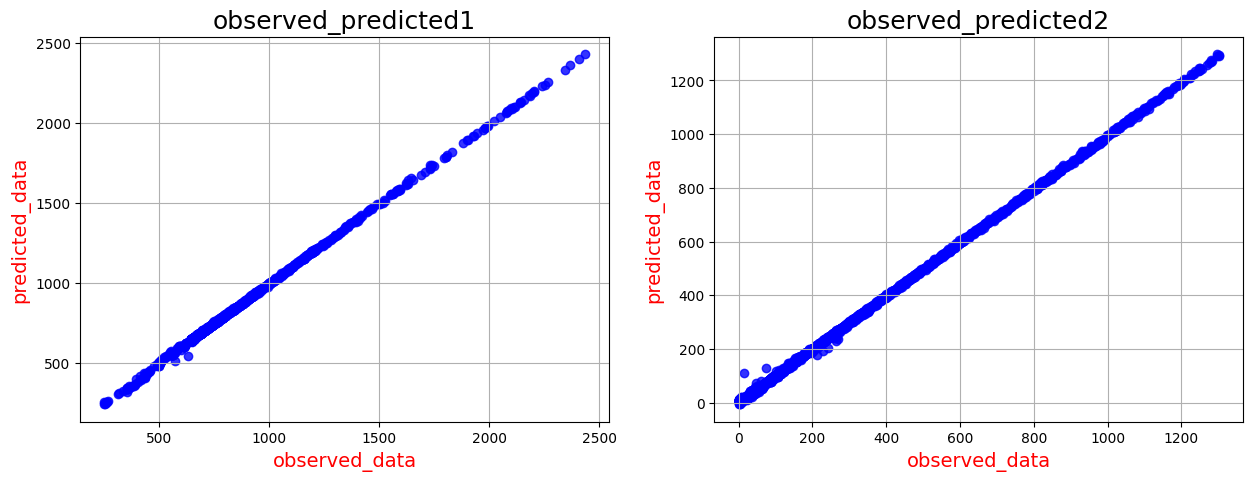

In [12]:
# Observed-Predicted Plot
# Figureを追加
fig = plt.figure(figsize = (15, 5))

# Output1 ====================================================================
# 1×2 の1枚目に描画する
yy1 = fig.add_subplot(1, 2, 1)

yy1.scatter(y_test.iloc[:, 0], pred1, c='blue', alpha=0.8)

# グラフ設定
yy1.set_title("observed_predicted1", size = 18)
yy1.grid()
yy1.set_xlabel("observed_data", size = 14, color = "r")
yy1.set_ylabel("predicted_data", size = 14, color = "r")

# Output2 ====================================================================
# 1×2 の2枚目に描画する
yy2 = fig.add_subplot(1, 2, 2)

yy2.scatter(y_test.iloc[:, 1], pred2, c='blue', alpha=0.8)

# グラフ設定
yy2.set_title("observed_predicted2", size = 18)
yy2.grid()
yy2.set_xlabel("observed_data", size = 14, color = "r")
yy2.set_ylabel("predicted_data", size = 14, color = "r")

## 6. MOPSO実装
参考記事
- [粒子群最適化法(PSO)を救いたい](https://qiita.com/ganyariya/items/ae5a38a3537b06bd3842)
- [最適化アルゴリズムを実装していくぞ（粒子群最適化）](https://qiita.com/pocokhc/items/fa6dfebad1130f21ac25)
- [だれでも分かる多目的最適化問題超入門](https://qiita.com/sp4ghet/items/f3dfbfe24b0a9c4997ee)

In [27]:
# 各粒子を表現するためのクラス
class Particle:
    def __init__(self):
        self.position = np.array([np.random.uniform(0, 15), np.random.uniform(0, 1)])  # [c2, s], 粒子の現在の位置を初期化
        self.velocity = np.random.rand(2) # 粒子の速度を示す2次元ベクトルの初期化
        self.best_position = np.copy(self.position) # パーソナルベストの位置の初期化
        self.best_score = [float('inf'), float('inf')] #パーソナルベストのスコアの初期化

# 多目的粒子群最適化（MOPSO）クラス
class MOPSO:
    def __init__(self, num_particles, num_iterations, model):
        self.num_particles = num_particles # 粒子数
        self.num_iterations = num_iterations # 繰り返し回数
        self.particles = [Particle() for _ in range(num_particles)] # 粒子のリストを初期化
        self.gbest_position = np.array([np.random.uniform(0, 15), np.random.uniform(0, 1)]) # グローバルベストの位置の初期化
        self.gbest_positions_history = [] # グローバルベストの位置を保存するためのリスト
        self.gbest_score = [float('inf'), float('inf')] # グローバルベストのスコアの初期化
        self.gbest_scores_history = [] # グローバルベストのスコアを保存するためのリスト
        self.model = model # モデル

    # 多目的粒子群最適化（MOPSO）の主要なアルゴリズム
    def optimize(self):
        for _ in range(self.num_iterations): # num_iterationsの回数だけ繰り返し
            # すべての粒子に対してその位置での目的関数を評価
            for particle in self.particles:
                objectives = self.evaluate(particle.position)

                # パーソナルベストの更新
                if self.is_better(objectives, particle.best_score):
                    particle.best_score = objectives
                    particle.best_position = particle.position.copy()

                # グローバルベストの更新
                if self.is_better(objectives, self.gbest_score):
                    self.gbest_score = objectives
                    self.gbest_position = particle.position.copy()
                    self.gbest_positions_history.append(self.gbest_position.copy())
                    self.gbest_scores_history.append(self.gbest_score.copy())

            for particle in self.particles:
                # ハイパーパラメータ
                inertia = 0.5
                personal_attraction = 0.9
                global_attraction = 0.9
                r1 = np.random.rand(2)
                r2 = np.random.rand(2)

                # 粒子の速度と位置の更新
                cognitive = personal_attraction * r1 * (particle.best_position - particle.position) # パーソナルベスト
                social = global_attraction * r2 * (self.gbest_position - particle.position) # グローバルベスト
                particle.velocity = inertia * particle.velocity + cognitive + social # 加速度
                particle.position += particle.velocity # 更新

                # c2とsの範囲制約を適用
                particle.position[0] = np.clip(particle.position[0], 0, 15)
                particle.position[1] = np.clip(particle.position[1], 0, 1)

        return self.gbest_position, self.gbest_score

    # 目的関数を評価する関数
    def evaluate(self, position):
        predicted = self.model(tf.convert_to_tensor([position], dtype=tf.float32))
        obj1 = tf.reduce_mean(tf.square(predicted[0] - target_w11_max)).numpy()
        obj2 = tf.reduce_mean(tf.square(predicted[1] - target_BandGap1)).numpy()
        return [obj1, obj2]

    # 新しい目的関数の値が現在のベストの値よりも良いかどうかを判断する関数
    def is_better(self, objectives, best_objectives):
        return sum(objectives) < sum(best_objectives)

# 所望値を定数で設定
target_w11_max = tf.constant([1000.0], dtype=tf.float32)
target_BandGap1 = tf.constant([500.0], dtype=tf.float32)

# 多目的粒子群最適化アルゴリズムを実行
mopso = MOPSO(num_particles=30, num_iterations=100, model=model)
best_position, best_score = mopso.optimize()

# グローバルベストの位置
C2_scores = [score[0] for score in mopso.gbest_positions_history]
s_scores = [score[1] for score in mopso.gbest_positions_history]

# グローバルベストのスコア
obj1_scores = [score[0] for score in mopso.gbest_scores_history]
obj2_scores = [score[1] for score in mopso.gbest_scores_history]

# ベストポジションとスコアを出力
print("Best position:", best_position)
print("Best score:", best_score)

Best position: [5.47690653 0.15529706]
Best score: [0.0, 0.0]


(0.0, 500.0)

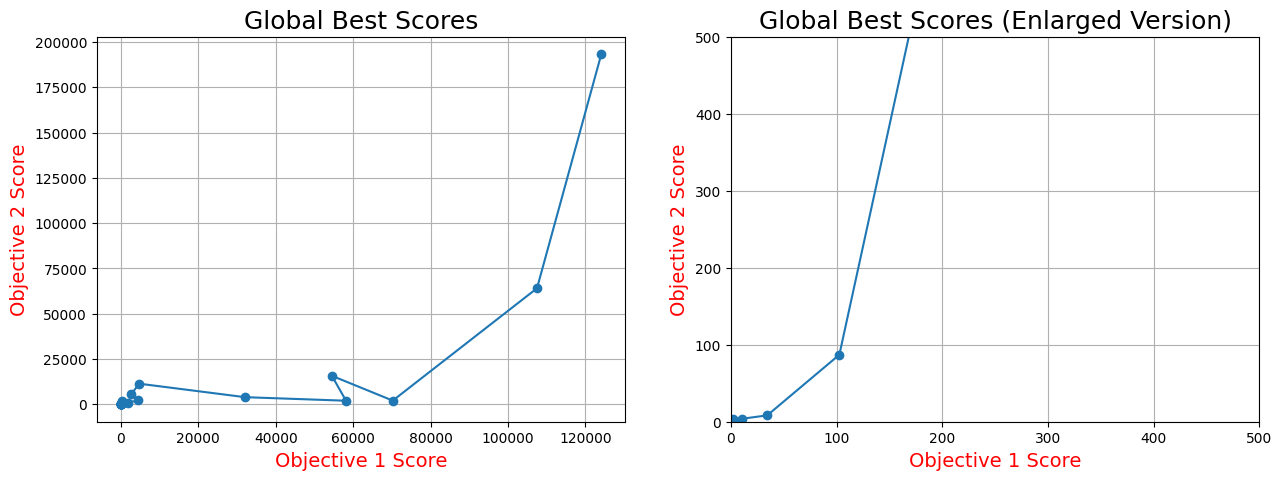

In [28]:
# 両方の目的関数が減っていくようなグローバルベストのスコアを二次元グラフにプロット
fig = plt.figure(figsize = (15, 5))

plt1 = fig.add_subplot(1, 2, 1)
plt1.plot(obj1_scores, obj2_scores, '-o')
plt1.set_xlabel('Objective 1 Score', size = 14, color = "r")
plt1.set_ylabel('Objective 2 Score', size = 14, color = "r")
plt1.set_title('Global Best Scores', size = 18)
plt1.grid(True)

# 拡大版
plt2 = fig.add_subplot(1, 2, 2)
plt2.plot(obj1_scores, obj2_scores, '-o')
plt2.set_xlabel('Objective 1 Score', size = 14, color = "r")
plt2.set_ylabel('Objective 2 Score', size = 14, color = "r")
plt2.set_title('Global Best Scores (Enlarged Version)', size = 18)
plt2.grid(True)
plt2.set_xlim(0, 500)
plt2.set_ylim(0, 500)

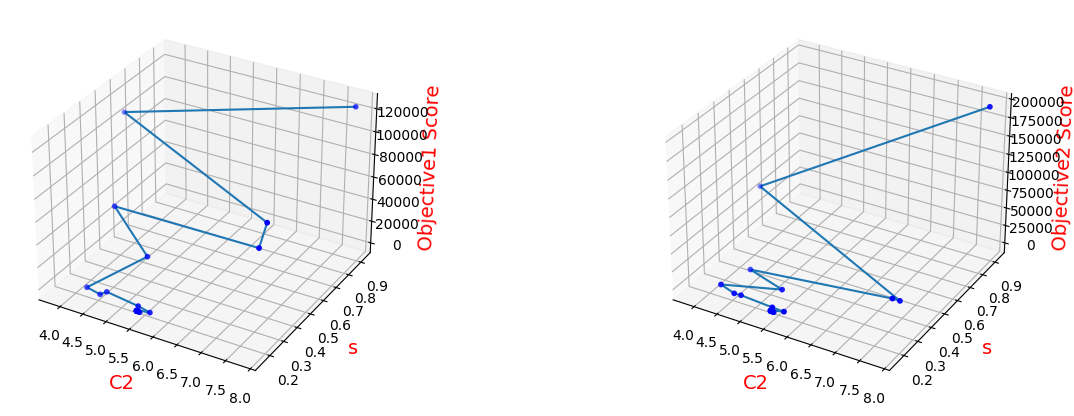

In [29]:
# 目的関数が減っていくようなC2とsのパラメータ更新を3次元グラフで可視化
fig = plt.figure(figsize = (15, 5))

# 3DAxesを追加
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# x,y,zに要素追加
x = np.array(C2_scores)
y = np.array(s_scores)
z1 = np.array(obj1_scores)
z2 = np.array(obj2_scores)

# 目的関数1
ax1.set_xlabel("C2", size = 14, color = "r")
ax1.set_ylabel("s", size = 14, color = "r")
ax1.set_zlabel("Objective1 Score", size = 14, color = "r")
ax1.plot(x, y, z1)
ax1.scatter(x, y, z1, s = 10, c = "blue")

# 目的関数2
ax2.set_xlabel("C2", size = 14, color = "r")
ax2.set_ylabel("s", size = 14, color = "r")
ax2.set_zlabel("Objective2 Score", size = 14, color = "r")
ax2.plot(x, y, z2)
ax2.scatter(x, y, z2, s = 10, c = "blue")

plt.show()

In [31]:
# 逆解析で得たパラメータを学習済みモデルに入力し、yの結果を得る
predicted_value = model.predict(np.array([[5.47690653, 0.15529706]]))

# yを確認
print("逆解析によって得られた入力パラメータによる一番下のバンド周波数は：", predicted_value[0][0][0], "Hz")
print("逆解析によって得られた入力パラメータによるバンドギャップの大きさは：", predicted_value[1][0][0], "Hz")

1/1 [==============================] - 0s 36ms/step
逆解析によって得られた入力パラメータによる一番下のバンド周波数は： 1000.0 Hz
逆解析によって得られた入力パラメータによるバンドギャップの大きさは： 500.0 Hz
